<a href="https://colab.research.google.com/github/ricardoV94/mbmlbook/blob/master/MBML_Chapter_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.figsize': (8,6)})

In [2]:
try:
    import arviz
except ImportError:
    !pip install arviz
    
import logging
logger = logging.getLogger('pymc3')
logger.propagate = False
logger.setLevel(logging.ERROR)

     |████████████████████████████████| 1.3MB 4.9MB/s 
     |████████████████████████████████| 4.1MB 41.0MB/s 
     |████████████████████████████████| 307kB 41.0MB/s 




---

##   4.2 A model for classification 

In [3]:
# data
data_toLine = np.array([0]*(19+3046) + [1]*(111+824))
data_repliedTo = np.array([1]*19 + [0]*3046 + [1]*111 + [0]*824)

[data_repliedTo[data_toLine==x].mean() for x in (0,1)]

[0.006199021207177814, 0.11871657754010695]

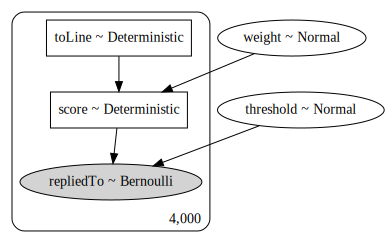

In [4]:
with pm.Model()as model1:
    size = data_toLine.size
    
    toLine = pm.Deterministic('toLine', theano.shared(data_toLine))
    weight = pm.Normal('weight', 0, np.sqrt(1))
    score = pm.Deterministic('score', tt.mul(toLine * weight))
    #noisyScore = pm.Normal('noisyScore', score, np.sqrt(10), shape=size)
    threshold = pm.Normal('threshold', 0, np.sqrt(10))
    repliedTo = pm.Bernoulli('repliedTo', pm.math.sigmoid(score + threshold), shape=size, observed=data_repliedTo)

pm.model_to_graphviz(model1)

In [5]:
with model1:
    post = pm.sample()

100%|██████████| 1000/1000 [00:04<00:00, 215.23it/s]
The estimated number of effective samples is smaller than 200 for some parameters.


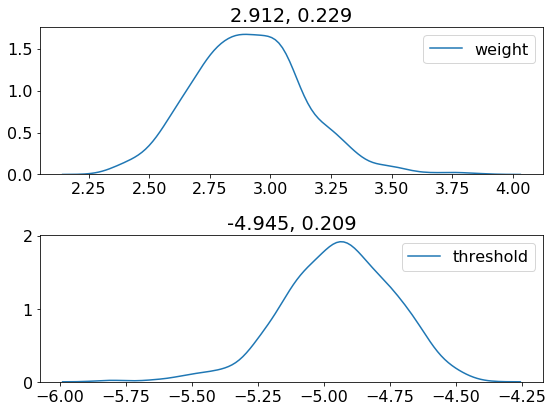

In [6]:
for i, param in enumerate(('weight', 'threshold'), 1):
    plt.subplot(2,1,i)
    sns.distplot(post[param], hist=False, label=param)
    plt.title(f"{np.mean(post[param]):.3f}, {np.std(post[param]):.3f}")
plt.tight_layout()

In [7]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

[np.round(np.mean(sigmoid(post['weight'] * x + post['threshold'])), 3) for x in (0,1)]

[0.007, 0.116]

##  4.3 Modelling multiple features 

In [0]:
def create_data(table):
    ncols = len(table[0]) - 1

    row = table[0]
    data = np.zeros((row[-1], ncols))
    data[:, :] = row[:-1]
    for row in table[1:]:
        dt = np.zeros((row[-1], ncols))
        dt[:, :] = row[:-1]
        data = np.vstack((data, dt))
    return data

data = create_data([[0,0,1, 19],
                    [0,0,0, 3046],
                    [1,0,1, 111],
                    [1,0,0, 824],
                    [0,1,1, 2],
                    [0,1,0, 248],
                    [1,1,1, 200],
                    [1,1,0, 50]])

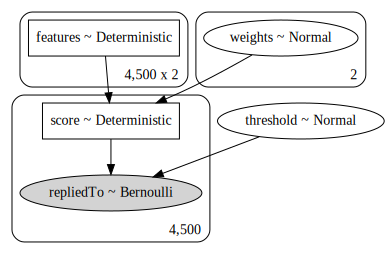

In [9]:
with pm.Model() as model2:
    features = pm.Deterministic('features', theano.shared(data[:,:-1]))
    weights = pm.Normal('weights', 0, np.sqrt(1), shape=data.shape[1]-1)
    
    score = pm.Deterministic('score', tt.sum(tt.mul(features*weights), axis=1))
    threshold = pm.Normal('threshold', 0, np.sqrt(10))
    repliedTo = pm.Bernoulli('repliedTo', pm.math.sigmoid(score + threshold), shape=data.shape[0], observed=data[:,-1])
    
pm.model_to_graphviz(model2)

In [10]:
with model2:
    post = pm.sample(draws=4000)

100%|██████████| 4500/4500 [00:38<00:00, 115.87it/s]


In [11]:
for f2 in (0,1):
    for f1 in (0,1):
        p = np.round(np.mean(sigmoid(np.sum(post['weights']*[f1, f2], axis=1) + post['threshold'])), 3)
        print(f1, f2, p)

0 0 0.003
1 0 0.132
0 1 0.06
1 1 0.737


Now with an interaction term

In [0]:
data2 = create_data([[0,0,0,1, 19],
                     [0,0,0,0, 3046],
                     [1,0,0,1, 111],
                     [1,0,0,0, 824],
                     [0,1,0,1, 2],
                     [0,1,0,0, 248],
                     [1,1,1,1, 200],
                     [1,1,1,0, 50]])

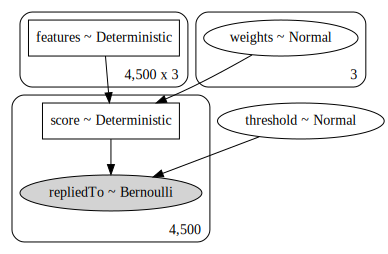

In [15]:
with pm.Model() as model3:
    model_data = data2
    features = pm.Deterministic('features', theano.shared(model_data[:,:-1]))
    weights = pm.Normal('weights', 0, np.sqrt(1), shape=model_data.shape[1]-1)
    
    score = pm.Deterministic('score', tt.sum(tt.mul(features*weights), axis=1))
    threshold = pm.Normal('threshold', 0, np.sqrt(10))
    repliedTo = pm.Bernoulli('repliedTo', pm.math.sigmoid(score + threshold), shape=model_data.shape[0], observed=model_data[:,-1])
    
pm.model_to_graphviz(model3)

In [16]:
with model3:
    post = pm.sample(draws=4000)

100%|██████████| 4500/4500 [00:47<00:00, 94.10it/s] 


In [17]:
for f2 in (0,1):
    for f1 in (0,1):
        f3 = f1*f2
        p = np.round(np.mean(sigmoid(np.sum(post['weights']*[f1, f2, f3], axis=1) + post['threshold'])), 3)
        print(f1, f2, p)

0 0 0.007
1 0 0.118
0 1 0.015
1 1 0.79
